In [92]:
import os
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import splitfolders

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
from keras.callbacks import ModelCheckpoint
from datetime import datetime
from keras.regularizers import l2, l1
from IPython.display import Audio
from datetime import datetime

Constants:

In [94]:
%store -r DATA_LOCATION 
%store -r GENRES

Functions:

In [93]:
def extract_features_from_file(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccsscaled


def extract_features(data, sample_rate):
    mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
    mfccsscaled = np.mean(mfccs.T,axis=0)
    return mfccsscaled


def add_noise(data):
    noise = np.random.randn(len(data))
    data_noise = data + 0.005 * noise
    return data_noise


def shift(data, sample_rate):
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())
    audio_shift = librosa.effects.pitch_shift(data.astype('float64'), sample_rate, n_steps=pitch_change, bins_per_octave=bins_per_octave)
    return audio_shift


def stretch(data):
    y_speed = data.copy()
    tmp = librosa.effects.time_stretch(data, 1.5)
    minlen = min(y_speed.shape[0], tmp.shape[0])
    y_speed *= 0 
    y_speed[0:minlen] = tmp[0:minlen]
    return y_speed    
    
    
def get_augmented_data(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        
        librosa_audio_shift = shift(audio, sample_rate)
        librosa_audio_with_noise = add_noise(audio)
        librosa_audio_stretch = stretch(audio)
    except Exception as e:
        print(e)
        print("Error encountered while parsing file: ", file_name)
        return None 
       
    return ([audio, librosa_audio_shift, librosa_audio_with_noise, librosa_audio_stretch], sample_rate)    


def fit_model(model, X, Y, x_test, y_test, epochs, batch_size, file_name):
    checkpoint = ModelCheckpoint("saved_models/" + file_name, verbose=1, save_best_only=True)
    
    start = datetime.now()
    history = model.fit(X, Y, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), callbacks=[checkpoint], 
                        verbose=1)
    
    duration = datetime.now() - start
    print("Training completed in time: ", duration)
    return history


def model_plot_validation(history):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(20, 6))
    
    ax0.set_title('Accuracy')
    ax0.plot(history.history['accuracy'])
    ax0.plot(history.history['val_accuracy'])
    ax0.legend(['train','validation'])

    ax1.set_title('Loss')
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.legend(['train','validation'])


def mlp_model():    
    model = Sequential()

    model.add(Dense(256, input_shape=(40,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(256))
    model.add(Activation('relu')) 
    model.add(Dropout(0.5))

    model.add(Dense(10))
    model.add(Activation('softmax'))
    return model

# Data Augmentation

With a view to reducing the overfiting of our model we may increase the amount of samples. Currently, we have a well-balanced dataset with 1000 samples (100 of each genre). What we want is to add new samples. To do this let's apply the next modifications on each train sample:
- Add noise
- Shift audio
- Stretch audio

Taking into account that we are spliting our data into training (800) and test (200), we will multiply the train data per 4. As a result, we will have 3200 samples for the training.

****Example:****

Next we will apply the aforementioned modifications to one of the samples (blues.00001.au).

In [95]:
filename = DATA_LOCATION + 'blues/blues.00001.au' 

librosa_audio, librosa_sample_rate = librosa.load(filename) 

_Original Audio:_

In [96]:
Audio(librosa_audio, rate=librosa_sample_rate)

_Audio with noise:_

In [97]:
librosa_audio_with_noise = add_noise(librosa_audio)
Audio(librosa_audio_with_noise, rate=librosa_sample_rate)

_Shift audio:_

In [98]:
librosa_audio_shift = shift(librosa_audio, librosa_sample_rate)
Audio(librosa_audio_shift, rate=librosa_sample_rate)

_Stretched Audio:_ 

In [99]:
librosa_audio_stretch = stretch(librosa_audio)
Audio(stretch(librosa_audio_stretch), rate=librosa_sample_rate)

As we have the samples saved in one folder, we need to create two new folders for saving in one the train data and in the other one the test data:

In [ ]:
splitfolders.ratio(DATA_LOCATION, output="./data", seed=1337, ratio=(.8, .2)) 

These are the new location of the audio files:

In [13]:
data_train_location = "data/train/"
data_test_location = "data/val/"

As in the other notebook, let's read the audio files and calculate the MCCs coeficients. This time we will also calculate the augmented audios and get their MCCs coefficients.

**Calculate Train features:**

In [24]:
features = []
for genre in GENRES:
    for i in range(100):
        file_name = os.path.join(os.path.abspath(data_train_location), genre + '/', genre + '.' + str(i).rjust(5, '0') + '.au')
        d = get_augmented_data(file_name)
        if d is not None:
            for augmented_audio in d[0]:
                data = extract_features(augmented_audio, d[1])
                features.append([data, genre])

features_aug_df = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(features_aug_df), ' files') 

C:\Users\Elvira\anaconda3\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\blues/blues.00013.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\blues/blues.00013.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\blues/blues.00021.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\blues/blues.00021.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\blues/blues.00026.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\blues/blues.00026.au
[Errno 2] No such file or direc

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\classical/classical.00049.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\classical/classical.00049.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\classical/classical.00050.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\classical/classical.00050.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\classical/classical.00051.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\classical/cl

C:\Users\Elvira\anaconda3\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\country/country.00013.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\country/country.00013.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\country/country.00021.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\country/country.00021.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\country/country.00026.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\country/country.00026.au
[Errno 

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\disco/disco.00046.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\disco/disco.00046.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\disco/disco.00049.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\disco/disco.00049.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\disco/disco.00050.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\disco/disco.00050.au
[Errno 2] No such file or direc

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\hiphop/hiphop.00073.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\hiphop/hiphop.00073.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\hiphop/hiphop.00074.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\hiphop/hiphop.00074.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\hiphop/hiphop.00079.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\hiphop/hiphop.00079.au
[Errno 2] No such f

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\jazz/jazz.00090.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\jazz/jazz.00090.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\jazz/jazz.00093.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\jazz/jazz.00093.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\jazz/jazz.00096.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\jazz/jazz.00096.au
[Errno 2] No such file or directory: 'C:\\U

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\pop/pop.00039.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\pop/pop.00039.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\pop/pop.00042.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\pop/pop.00042.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\pop/pop.00046.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\pop/pop.00046.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\reggae/reggae.00054.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\reggae/reggae.00054.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\reggae/reggae.00068.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\reggae/reggae.00068.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\reggae/reggae.00073.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\reggae/reggae.00073.au
[Errno 2] No such f

[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\rock/rock.00084.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\rock/rock.00084.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\rock/rock.00088.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\rock/rock.00088.au
[Errno 2] No such file or directory: 'C:\\Users\\Elvira\\Documents\\Estudios académicos\\Máster en Data Science\\7. Deep Learning\\data\\train\\rock/rock.00090.au'
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\train\rock/rock.00090.au
[Errno 2] No such file or directory: 'C:\\U

**Calculate Test features:**

For test data we don't apply the augmentation.

In [36]:
features = []
for genre in GENRES:
    for i in range(100):
        file_name = os.path.join(os.path.abspath(data_test_location), genre + '/', genre + '.' + str(i).rjust(5, '0') + '.au')
        data = extract_features_from_file(file_name)
        if data is not None:
            features.append([data, genre])

features_test_df = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(features_test_df), ' files') 

Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\blues/blues.00000.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\blues/blues.00001.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\blues/blues.00002.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\blues/blues.00003.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\blues/blues.00004.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\blues/blues.00005.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estud

Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\blues/blues.00063.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\blues/blues.00064.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\blues/blues.00065.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\blues/blues.00066.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\blues/blues.00067.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\blues/blues.00069.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estud

Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\classical/classical.00035.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\classical/classical.00036.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\classical/classical.00037.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\classical/classical.00038.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\classical/classical.00040.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\classical/classical.00041.au
Error encountered whil

Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\country/country.00009.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\country/country.00010.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\country/country.00011.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\country/country.00012.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\country/country.00014.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\country/country.00015.au
Error encountered while parsing file:  C:\User

Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\country/country.00075.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\country/country.00076.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\country/country.00077.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\country/country.00078.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\country/country.00080.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\country/country.00082.au
Error encountered while parsing file:  C:\User

Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\disco/disco.00040.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\disco/disco.00041.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\disco/disco.00043.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\disco/disco.00044.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\disco/disco.00045.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\disco/disco.00047.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estud

Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\hiphop/hiphop.00075.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\hiphop/hiphop.00076.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\hiphop/hiphop.00077.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\hiphop/hiphop.00078.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\hiphop/hiphop.00080.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\hiphop/hiphop.00082.au
Error encountered while parsing file:  C:\Users\Elvira\Doc

Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\jazz/jazz.00040.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\jazz/jazz.00041.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\jazz/jazz.00043.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\jazz/jazz.00044.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\jazz/jazz.00045.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\jazz/jazz.00047.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académic

Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\metal/metal.00014.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\metal/metal.00015.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\metal/metal.00016.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\metal/metal.00017.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\metal/metal.00018.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\metal/metal.00019.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estud

Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\metal/metal.00080.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\metal/metal.00082.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\metal/metal.00083.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\metal/metal.00085.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\metal/metal.00086.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\metal/metal.00087.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estud

Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\pop/pop.00047.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\pop/pop.00048.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\pop/pop.00052.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\pop/pop.00053.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\pop/pop.00055.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\pop/pop.00056.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en

Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\reggae/reggae.00022.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\reggae/reggae.00023.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\reggae/reggae.00024.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\reggae/reggae.00025.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\reggae/reggae.00027.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\reggae/reggae.00028.au
Error encountered while parsing file:  C:\Users\Elvira\Doc

Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\rock/rock.00058.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\rock/rock.00059.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\rock/rock.00060.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\rock/rock.00061.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\rock/rock.00062.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académicos\Máster en Data Science\7. Deep Learning\data\val\rock/rock.00063.au
Error encountered while parsing file:  C:\Users\Elvira\Documents\Estudios académic

Next we need to prepare the data format for our model:

In [43]:
x_train_aug = np.array(features_aug_df.feature.tolist())
y_aug = np.array(features_aug_df.class_label.tolist())
x_test_aug = np.array(features_test_df.feature.tolist())
y_test_aug = np.array(features_test_df.class_label.tolist())

le = LabelEncoder()
y_train_aug = to_categorical(le.fit_transform(y_aug))
y_test_aug = to_categorical(le.fit_transform(y_test_aug)) 

Now, let's apply the data augmentation to the best MLP model:

In [56]:
mlp_model1 = mlp_model();

mlp_model1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [57]:
mlp_model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               10496     
_________________________________________________________________
activation_10 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_11 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)               

In [58]:
history = fit_model(mlp_model1, x_train_aug, y_train_aug, x_test_aug, y_test_aug, epochs=100, batch_size=32, 
                    file_name='mlpaug.hdf5')

Epoch 1/100
100/100 [==============================] - 2s 10ms/step - loss: 23.3148 - accuracy: 0.1309 - val_loss: 2.0679 - val_accuracy: 0.3100

Epoch 00001: val_loss improved from inf to 2.06787, saving model to saved_models\mlpaug.hdf5
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 3.5526 - accuracy: 0.1633 - val_loss: 2.1483 - val_accuracy: 0.1800

Epoch 00002: val_loss did not improve from 2.06787
Epoch 3/100
100/100 [==============================] - 0s 3ms/step - loss: 2.4117 - accuracy: 0.2024 - val_loss: 2.0947 - val_accuracy: 0.2400

Epoch 00003: val_loss did not improve from 2.06787
Epoch 4/100
100/100 [==============================] - 0s 3ms/step - loss: 2.2360 - accuracy: 0.2023 - val_loss: 2.0185 - val_accuracy: 0.3300

Epoch 00004: val_loss improved from 2.06787 to 2.01850, saving model to saved_models\mlpaug.hdf5
Epoch 5/100
100/100 [==============================] - 0s 3ms/step - loss: 2.1433 - accuracy: 0.2297 - val_loss: 1.9376 - val_accu

100/100 [==============================] - 0s 3ms/step - loss: 1.1648 - accuracy: 0.5973 - val_loss: 1.1102 - val_accuracy: 0.6300

Epoch 00037: val_loss did not improve from 1.08251
Epoch 38/100
100/100 [==============================] - 0s 3ms/step - loss: 1.1063 - accuracy: 0.6031 - val_loss: 1.1197 - val_accuracy: 0.6200

Epoch 00038: val_loss did not improve from 1.08251
Epoch 39/100
100/100 [==============================] - 0s 3ms/step - loss: 1.1266 - accuracy: 0.5892 - val_loss: 1.0873 - val_accuracy: 0.6600

Epoch 00039: val_loss did not improve from 1.08251
Epoch 40/100
100/100 [==============================] - 0s 3ms/step - loss: 1.0978 - accuracy: 0.6038 - val_loss: 1.1557 - val_accuracy: 0.6400

Epoch 00040: val_loss did not improve from 1.08251
Epoch 41/100
100/100 [==============================] - 0s 3ms/step - loss: 1.0597 - accuracy: 0.6305 - val_loss: 1.1033 - val_accuracy: 0.6400

Epoch 00041: val_loss did not improve from 1.08251
Epoch 42/100
100/100 [===========

100/100 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.7562 - val_loss: 1.1763 - val_accuracy: 0.6750

Epoch 00079: val_loss did not improve from 1.08251
Epoch 80/100
100/100 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.7626 - val_loss: 1.2770 - val_accuracy: 0.6400

Epoch 00080: val_loss did not improve from 1.08251
Epoch 81/100
100/100 [==============================] - 0s 3ms/step - loss: 0.6680 - accuracy: 0.7653 - val_loss: 1.2367 - val_accuracy: 0.6800

Epoch 00081: val_loss did not improve from 1.08251
Epoch 82/100
100/100 [==============================] - 0s 4ms/step - loss: 0.6615 - accuracy: 0.7685 - val_loss: 1.3322 - val_accuracy: 0.6200

Epoch 00082: val_loss did not improve from 1.08251
Epoch 83/100
100/100 [==============================] - 0s 4ms/step - loss: 0.6459 - accuracy: 0.7627 - val_loss: 1.2135 - val_accuracy: 0.6850

Epoch 00083: val_loss did not improve from 1.08251
Epoch 84/100
100/100 [===========

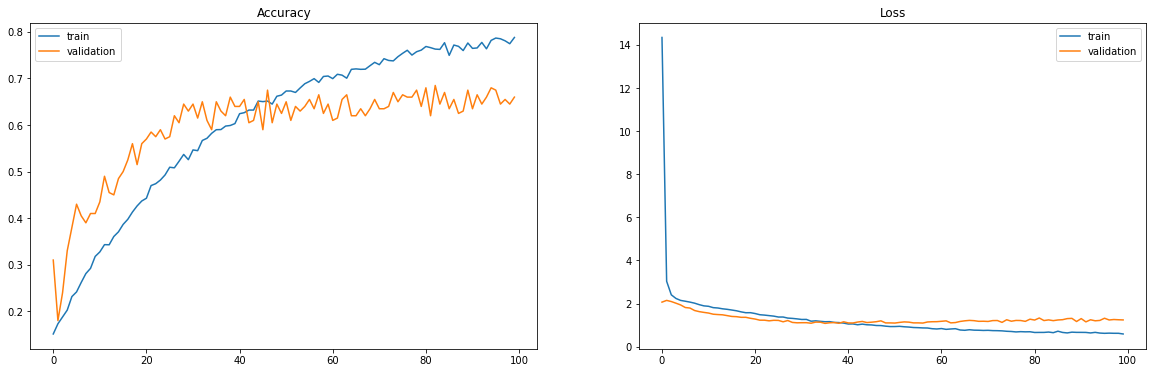

In [60]:
model_plot_validation(history)

In [61]:
score = mlp_model1.evaluate(x_train_aug, y_train_aug, verbose=0)
print("Training Accuracy: ", score[1])
print("Training Loss: ", score[0])


score = mlp_model1.evaluate(x_test_aug, y_test_aug, verbose=0)
print("Testing Accuracy: ", score[1])
print("Testing Loss: ", score[0])

Training Accuracy:  0.9390624761581421
Training Loss:  0.28372418880462646
Testing Accuracy:  0.6600000262260437
Training Loss:  1.2424511909484863


It has improved a bit the accuray and the loss:
- Training:    
    - Before - 92%
    - After - 93% 
- Test:
    - Before - 65%
    - After - 66% 

**Some training modifications**

With the chosen model let's see if we could improve the performance by modifying the number of _epochs_ and the _batch_ size. 

First we will begin adding more epochs in order to see how is the accuracy and loss behaviour in the next epochs.

In [63]:
mlp_model2 = mlp_model();
mlp_model2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Let's set **150 epochs**:

In [64]:
history = fit_model(mlp_model2, x_train_aug, y_train_aug, x_test_aug, y_test_aug, epochs=150, batch_size=32, 
                    file_name='mlp2aug.hdf5')

Epoch 1/150
100/100 [==============================] - 1s 7ms/step - loss: 19.6199 - accuracy: 0.1267 - val_loss: 2.0006 - val_accuracy: 0.3350

Epoch 00001: val_loss improved from inf to 2.00058, saving model to saved_models\mlp2aug.hdf5
Epoch 2/150
100/100 [==============================] - 0s 3ms/step - loss: 3.3633 - accuracy: 0.1864 - val_loss: 2.0574 - val_accuracy: 0.2300

Epoch 00002: val_loss did not improve from 2.00058
Epoch 3/150
100/100 [==============================] - 0s 3ms/step - loss: 2.3721 - accuracy: 0.1988 - val_loss: 1.9839 - val_accuracy: 0.2250

Epoch 00003: val_loss improved from 2.00058 to 1.98392, saving model to saved_models\mlp2aug.hdf5
Epoch 4/150
100/100 [==============================] - 0s 3ms/step - loss: 2.1484 - accuracy: 0.2356 - val_loss: 1.8969 - val_accuracy: 0.3350

Epoch 00004: val_loss improved from 1.98392 to 1.89695, saving model to saved_models\mlp2aug.hdf5
Epoch 5/150
100/100 [==============================] - 0s 3ms/step - loss: 2.1213 

100/100 [==============================] - 0s 3ms/step - loss: 0.9894 - accuracy: 0.6433 - val_loss: 1.1634 - val_accuracy: 0.6250

Epoch 00038: val_loss did not improve from 1.06867
Epoch 39/150
100/100 [==============================] - 0s 3ms/step - loss: 1.0241 - accuracy: 0.6282 - val_loss: 1.1584 - val_accuracy: 0.6100

Epoch 00039: val_loss did not improve from 1.06867
Epoch 40/150
100/100 [==============================] - 0s 4ms/step - loss: 1.0287 - accuracy: 0.6359 - val_loss: 1.0958 - val_accuracy: 0.6250

Epoch 00040: val_loss did not improve from 1.06867
Epoch 41/150
100/100 [==============================] - 0s 3ms/step - loss: 1.0354 - accuracy: 0.6386 - val_loss: 1.1098 - val_accuracy: 0.6600

Epoch 00041: val_loss did not improve from 1.06867
Epoch 42/150
100/100 [==============================] - 0s 3ms/step - loss: 0.9667 - accuracy: 0.6652 - val_loss: 1.1254 - val_accuracy: 0.6650

Epoch 00042: val_loss did not improve from 1.06867
Epoch 43/150
100/100 [===========

100/100 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.7490 - val_loss: 1.3879 - val_accuracy: 0.6200

Epoch 00080: val_loss did not improve from 1.06867
Epoch 81/150
100/100 [==============================] - 0s 5ms/step - loss: 0.6881 - accuracy: 0.7600 - val_loss: 1.3929 - val_accuracy: 0.6200

Epoch 00081: val_loss did not improve from 1.06867
Epoch 82/150
100/100 [==============================] - 1s 5ms/step - loss: 0.7338 - accuracy: 0.7459 - val_loss: 1.5450 - val_accuracy: 0.5900

Epoch 00082: val_loss did not improve from 1.06867
Epoch 83/150
100/100 [==============================] - 0s 3ms/step - loss: 0.6853 - accuracy: 0.7609 - val_loss: 1.4749 - val_accuracy: 0.6150

Epoch 00083: val_loss did not improve from 1.06867
Epoch 84/150
100/100 [==============================] - 0s 3ms/step - loss: 0.6828 - accuracy: 0.7537 - val_loss: 1.3449 - val_accuracy: 0.6300

Epoch 00084: val_loss did not improve from 1.06867
Epoch 85/150
100/100 [===========

100/100 [==============================] - 0s 4ms/step - loss: 0.6059 - accuracy: 0.7832 - val_loss: 1.5806 - val_accuracy: 0.6550

Epoch 00122: val_loss did not improve from 1.06867
Epoch 123/150
100/100 [==============================] - 0s 3ms/step - loss: 0.5587 - accuracy: 0.8053 - val_loss: 1.6016 - val_accuracy: 0.6500

Epoch 00123: val_loss did not improve from 1.06867
Epoch 124/150
100/100 [==============================] - 0s 3ms/step - loss: 0.5827 - accuracy: 0.8129 - val_loss: 1.6044 - val_accuracy: 0.6150

Epoch 00124: val_loss did not improve from 1.06867
Epoch 125/150
100/100 [==============================] - 0s 4ms/step - loss: 0.5611 - accuracy: 0.8105 - val_loss: 1.6207 - val_accuracy: 0.6450

Epoch 00125: val_loss did not improve from 1.06867
Epoch 126/150
100/100 [==============================] - 0s 4ms/step - loss: 0.5748 - accuracy: 0.8007 - val_loss: 1.5207 - val_accuracy: 0.6400

Epoch 00126: val_loss did not improve from 1.06867
Epoch 127/150
100/100 [======

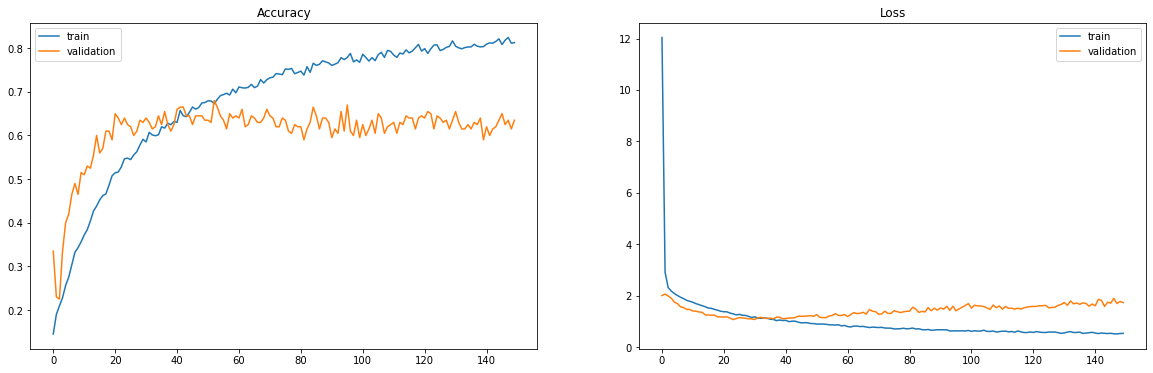

In [65]:
model_plot_validation(history)

In [66]:
score = mlp_model2.evaluate(x_train_aug, y_train_aug, verbose=0)
print("Training Accuracy: ", score[1])
print("Training Loss: ", score[0])


score = mlp_model2.evaluate(x_test_aug, y_test_aug, verbose=0)
print("Testing Accuracy: ", score[1])
print("Training Loss: ", score[0])

Training Accuracy:  0.9599999785423279
Training Loss:  0.22586312890052795
Testing Accuracy:  0.6349999904632568
Training Loss:  1.7271640300750732


As we may see by adding more epochs we don't see any improvement in the validation dataset.

Secondly, we will try two more different batches:
- 64

In [67]:
mlp_model3 = mlp_model();
mlp_model3.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [68]:
history = fit_model(mlp_model3, x_train_aug, y_train_aug, x_test_aug, y_test_aug, epochs=100, batch_size=64, 
                    file_name='mlp3aug.hdf5')

Epoch 1/100
50/50 [==============================] - 1s 10ms/step - loss: 20.1059 - accuracy: 0.1258 - val_loss: 2.1223 - val_accuracy: 0.2600

Epoch 00001: val_loss improved from inf to 2.12230, saving model to saved_models\mlp3aug.hdf5
Epoch 2/100
50/50 [==============================] - 0s 4ms/step - loss: 4.4695 - accuracy: 0.1963 - val_loss: 2.0607 - val_accuracy: 0.2700

Epoch 00002: val_loss improved from 2.12230 to 2.06074, saving model to saved_models\mlp3aug.hdf5
Epoch 3/100
50/50 [==============================] - 0s 5ms/step - loss: 2.5949 - accuracy: 0.1886 - val_loss: 2.0396 - val_accuracy: 0.2900

Epoch 00003: val_loss improved from 2.06074 to 2.03963, saving model to saved_models\mlp3aug.hdf5
Epoch 4/100
50/50 [==============================] - 0s 5ms/step - loss: 2.3217 - accuracy: 0.1938 - val_loss: 1.9799 - val_accuracy: 0.3150

Epoch 00004: val_loss improved from 2.03963 to 1.97993, saving model to saved_models\mlp3aug.hdf5
Epoch 5/100
50/50 [=======================

50/50 [==============================] - 0s 5ms/step - loss: 1.1665 - accuracy: 0.5678 - val_loss: 1.1052 - val_accuracy: 0.6550

Epoch 00036: val_loss did not improve from 1.09920
Epoch 37/100
50/50 [==============================] - 0s 4ms/step - loss: 1.1926 - accuracy: 0.5545 - val_loss: 1.0834 - val_accuracy: 0.6250

Epoch 00037: val_loss improved from 1.09920 to 1.08344, saving model to saved_models\mlp3aug.hdf5
Epoch 38/100
50/50 [==============================] - 0s 4ms/step - loss: 1.1926 - accuracy: 0.5803 - val_loss: 1.1017 - val_accuracy: 0.6500

Epoch 00038: val_loss did not improve from 1.08344
Epoch 39/100
50/50 [==============================] - 0s 4ms/step - loss: 1.1619 - accuracy: 0.5811 - val_loss: 1.0635 - val_accuracy: 0.6550

Epoch 00039: val_loss improved from 1.08344 to 1.06350, saving model to saved_models\mlp3aug.hdf5
Epoch 40/100
50/50 [==============================] - 0s 9ms/step - loss: 1.1259 - accuracy: 0.5966 - val_loss: 1.1209 - val_accuracy: 0.6400




Epoch 00077: val_loss did not improve from 1.02714
Epoch 78/100
50/50 [==============================] - 0s 4ms/step - loss: 0.7282 - accuracy: 0.7395 - val_loss: 1.1879 - val_accuracy: 0.6450

Epoch 00078: val_loss did not improve from 1.02714
Epoch 79/100
50/50 [==============================] - 0s 5ms/step - loss: 0.7218 - accuracy: 0.7421 - val_loss: 1.1455 - val_accuracy: 0.6550

Epoch 00079: val_loss did not improve from 1.02714
Epoch 80/100
50/50 [==============================] - 0s 5ms/step - loss: 0.7173 - accuracy: 0.7429 - val_loss: 1.1672 - val_accuracy: 0.6400

Epoch 00080: val_loss did not improve from 1.02714
Epoch 81/100
50/50 [==============================] - 0s 4ms/step - loss: 0.7278 - accuracy: 0.7303 - val_loss: 1.1673 - val_accuracy: 0.6500

Epoch 00081: val_loss did not improve from 1.02714
Epoch 82/100
50/50 [==============================] - 0s 4ms/step - loss: 0.7363 - accuracy: 0.7337 - val_loss: 1.1563 - val_accuracy: 0.6550

Epoch 00082: val_loss did not

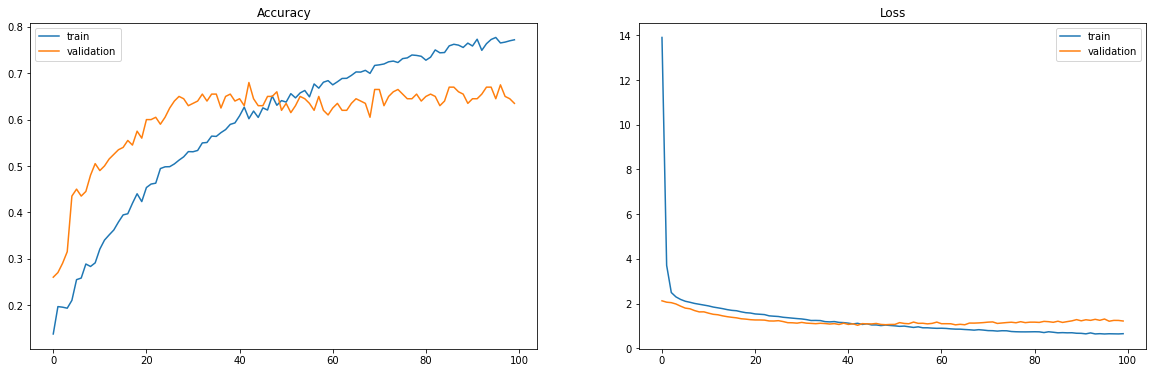

In [69]:
model_plot_validation(history)

In [70]:
score = mlp_model3.evaluate(x_train_aug, y_train_aug, verbose=0)
print("Training Accuracy: ", score[1])
print("Training Loss: ", score[0])


score = mlp_model3.evaluate(x_test_aug, y_test_aug, verbose=0)
print("Testing Accuracy: ", score[1])
print("Training Loss: ", score[0])

Training Accuracy:  0.918749988079071
Training Loss:  0.3396596908569336
Testing Accuracy:  0.6349999904632568
Training Loss:  1.218837022781372


- 128

In [71]:
mlp_model4 = mlp_model();
mlp_model4.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [74]:
history = fit_model(mlp_model4, x_train_aug, y_train_aug, x_test_aug, y_test_aug, epochs=100, batch_size=128, 
                    file_name='mlp4aug.hdf5')

Epoch 1/100
25/25 [==============================] - 0s 10ms/step - loss: 1.7599 - accuracy: 0.3625 - val_loss: 1.4551 - val_accuracy: 0.4750

Epoch 00001: val_loss improved from inf to 1.45509, saving model to saved_models\mlp4aug.hdf5
Epoch 2/100
25/25 [==============================] - 0s 9ms/step - loss: 1.7327 - accuracy: 0.3825 - val_loss: 1.4550 - val_accuracy: 0.4800

Epoch 00002: val_loss improved from 1.45509 to 1.45502, saving model to saved_models\mlp4aug.hdf5
Epoch 3/100
25/25 [==============================] - 0s 9ms/step - loss: 1.7287 - accuracy: 0.3728 - val_loss: 1.4305 - val_accuracy: 0.4900

Epoch 00003: val_loss improved from 1.45502 to 1.43054, saving model to saved_models\mlp4aug.hdf5
Epoch 4/100
25/25 [==============================] - 0s 10ms/step - loss: 1.7036 - accuracy: 0.3716 - val_loss: 1.4253 - val_accuracy: 0.4900

Epoch 00004: val_loss improved from 1.43054 to 1.42530, saving model to saved_models\mlp4aug.hdf5
Epoch 5/100
25/25 [=======================


Epoch 00038: val_loss did not improve from 1.15781
Epoch 39/100
25/25 [==============================] - 0s 10ms/step - loss: 1.2444 - accuracy: 0.5578 - val_loss: 1.2274 - val_accuracy: 0.5700

Epoch 00039: val_loss did not improve from 1.15781
Epoch 40/100
25/25 [==============================] - 0s 14ms/step - loss: 1.2259 - accuracy: 0.5569 - val_loss: 1.1583 - val_accuracy: 0.6050

Epoch 00040: val_loss did not improve from 1.15781
Epoch 41/100
25/25 [==============================] - 0s 9ms/step - loss: 1.2278 - accuracy: 0.5650 - val_loss: 1.1646 - val_accuracy: 0.6100

Epoch 00041: val_loss did not improve from 1.15781
Epoch 42/100
25/25 [==============================] - 0s 13ms/step - loss: 1.2150 - accuracy: 0.5622 - val_loss: 1.1751 - val_accuracy: 0.5700

Epoch 00042: val_loss did not improve from 1.15781
Epoch 43/100
25/25 [==============================] - 0s 17ms/step - loss: 1.2070 - accuracy: 0.5663 - val_loss: 1.2162 - val_accuracy: 0.5800

Epoch 00043: val_loss did


Epoch 00079: val_loss did not improve from 1.11385
Epoch 80/100
25/25 [==============================] - 0s 10ms/step - loss: 0.8676 - accuracy: 0.6991 - val_loss: 1.2059 - val_accuracy: 0.6400

Epoch 00080: val_loss did not improve from 1.11385
Epoch 81/100
25/25 [==============================] - 0s 10ms/step - loss: 0.8740 - accuracy: 0.6888 - val_loss: 1.1942 - val_accuracy: 0.6350

Epoch 00081: val_loss did not improve from 1.11385
Epoch 82/100
25/25 [==============================] - 0s 12ms/step - loss: 0.8737 - accuracy: 0.6894 - val_loss: 1.1902 - val_accuracy: 0.6400

Epoch 00082: val_loss did not improve from 1.11385
Epoch 83/100
25/25 [==============================] - 0s 10ms/step - loss: 0.8490 - accuracy: 0.6894 - val_loss: 1.2751 - val_accuracy: 0.6400

Epoch 00083: val_loss did not improve from 1.11385
Epoch 84/100
25/25 [==============================] - 0s 10ms/step - loss: 0.8327 - accuracy: 0.7097 - val_loss: 1.2329 - val_accuracy: 0.6450

Epoch 00084: val_loss di

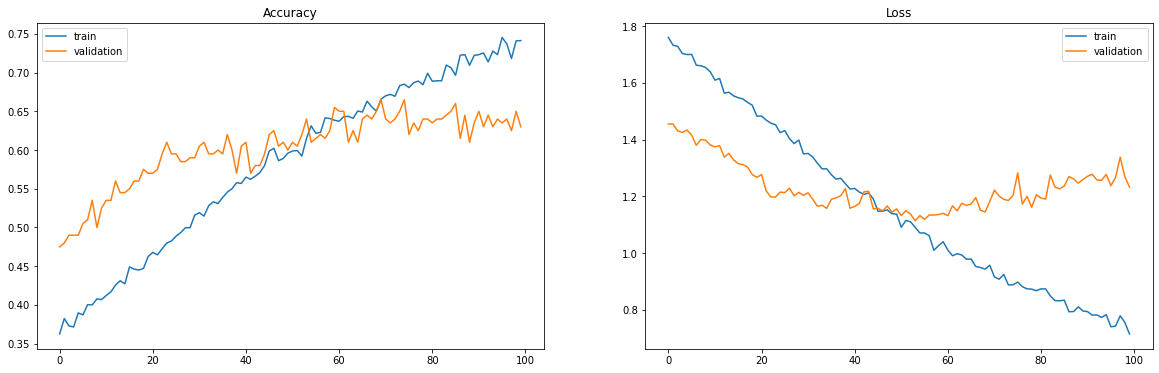

In [75]:
model_plot_validation(history)

In [76]:
score = mlp_model4.evaluate(x_train_aug, y_train_aug, verbose=0)
print("Training Accuracy: ", score[1])
print("Training Loss: ", score[0])


score = mlp_model4.evaluate(x_test_aug, y_test_aug, verbose=0)
print("Testing Accuracy: ", score[1])
print("Training Loss: ", score[0])

Training Accuracy:  0.8871874809265137
Training Loss:  0.43987175822257996
Testing Accuracy:  0.6299999952316284
Training Loss:  1.232448697090149


As we may see by increasing the batch size we didn't reach any improvement for the validation data.

Finally, we store the following variables for the next notebooks:

In [90]:
%store data_train_location
%store data_test_location

Stored 'data_train_location' (str)
Stored 'data_test_location' (str)


In [62]:
%store x_train_aug
%store x_test_aug 
%store y_train_aug 
%store y_test_aug

Stored 'x_train_aug' (ndarray)
Stored 'x_test_aug' (ndarray)
Stored 'y_train_aug' (ndarray)
Stored 'y_test_aug' (ndarray)


In [91]:
%store le

Stored 'le' (LabelEncoder)
